In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from evolutionary.nsga import NSGA
import requests

In [2]:
def get_close(symbol, name):
    # get ohlc data from kraken api
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval=1'
    response = requests.get(url)
    data = response.json()
    ohlc_data = data['result'][name]
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'wavg price', 'count']
    # create df
    df = pd.DataFrame(ohlc_data, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    # we only take close data
    df.drop(columns=['volume', 'wavg price', 'count', 'open', 'high', 'low'], inplace=True)
    df['close'] = df['close'].apply(pd.to_numeric, errors='coerce')
    df.set_index('timestamp',inplace=True)
    return df

# key is symbol, value is the name used by kraken
cryptos = {"LINKUSD":"LINKUSD" , "MATICUSD":"MATICUSD", "BTCUSD":"XXBTZUSD", "ETHUSD":"XETHZUSD"}

data_frames = {crypto:get_close(crypto, cryptos[crypto]) for crypto in cryptos}

# add normalised closed prices
for coin in data_frames: 
    data_frames[coin]['nclose'] = data_frames[coin]['close'] / data_frames[coin]['close'].iloc[0] 

# # Create a SQLite database connection
# db_conn = sqlite3.connect("PairsTradingData.db")

# # Instantiate the OHLCV class with the database connection
# ohlc_reader = util.OHLCV(db_conn)

# # Call the load method with the required parameters
# c
# exchanges = ["binance" for _ in range(len(cryptos))]
# since_date = "2024-01-01 00:01:00"

# data_frames = ohlc_reader.load(cryptos, exchanges, since_date)

In [3]:
long = ['BTCUSD', 'LINKUSD']
short = ['MATICUSD', 'ETHUSD']

def get_spread(weights):
    df = pd.DataFrame()
    df['spread'] = weights[0] * data_frames[long[0]]['nclose']
    for i in range(1, len(long)):
        df['spread'] = df['spread'] + (weights[i] * data_frames[long[i]]['nclose'])
    for i in range(len(short)):
        df['spread'] = df['spread'] + (-weights[i+len(long)] * data_frames[short[i]]['nclose'])
    return df['spread']

def optimise(functions, population=None, num_generations=10):
    nsga = NSGA(functions, lambda x : get_spread(x), chromosome_size=len(long)+len(short))
    if population is None: population = nsga.generate_population()
    print("Generation 0")
    for i in range(num_generations):
        population = nsga.evolve(population)
        print("Generation ", i+1)
        print("Average Norm: ", nsga.avg_objective(population, 0))
        print("Average NZC: ",
              nsga.avg_objective(population, 1))
        print(population)
    _, optimal = nsga.nd_sort(population)
    best = np.array([population[i] for i in optimal[0]]) # finds pareto optimal front in final population
    return best

# Chromosome layout for NSGA: weights for long cryptos followed by weights for short cryptos


# Objective functions

def nzc(spread):
    # counts how many sign changes in the spread (number of zeros crossed)
    return np.where(np.diff(np.signbit(spread)))[0].size

def coeff_variation(spread):
    return np.std(spread)/np.mean(spread)

def norm(spread):
    return np.linalg.norm(spread)

def gap(spread):
    return abs(spread.iloc[-1])

functions = [lambda spread : norm(spread), lambda spread: -nzc(spread)]

frontier = optimise(functions, num_generations=40)
print(frontier)



Generation 0
Generation  1
Average Norm:  5.550874269413167
Average NZC:  -7.9
[[0.92234654 0.5745072  0.82574631 0.69035532]
 [0.92234654 0.5745072  0.82574631 0.69035532]
 [0.37694651 0.55986717 0.78519912 0.16158228]
 [0.33590247 0.55789844 0.76161515 0.17085006]
 [0.72713342 0.63707368 0.78553117 0.79871082]
 [0.68608938 0.63510496 0.76194719 0.80797861]
 [0.19215123 0.88878977 0.73301109 0.60767979]
 [0.68671757 0.9469401  0.72060317 0.60758145]
 [0.72408486 0.00330036 0.54202978 0.60491602]
 [0.14903727 0.69984139 0.77605654 0.60143302]]
Generation  2
Average Norm:  2.655505159202055
Average NZC:  -7.9
[[0.92234654 0.5745072  0.82574631 0.69035532]
 [0.92234654 0.5745072  0.82574631 0.69035532]
 [0.37694651 0.55986717 0.78519912 0.16158228]
 [0.33590247 0.55789844 0.76161515 0.17085006]
 [0.39621203 0.55069568 0.71983748 0.18461045]
 [0.88443416 0.69863377 0.82427169 0.68079448]
 [0.74905201 0.5133915  0.76181954 0.60154773]
 [0.72713342 0.63707368 0.78553117 0.79871082]
 [0.7262

KeyboardInterrupt: 

ADF test statistic: -0.7663911077066604
ADF p value: 0.8287956692096188
Number of Zeroes Crossed: 38
Coefficient of variation: 1.3207461825110745
Norm: 0.2398253960309692


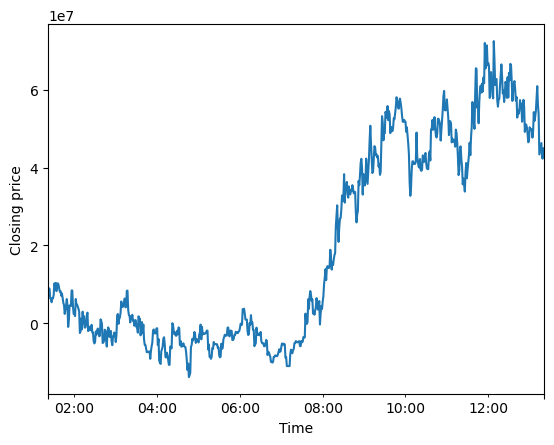

In [7]:
unnormalised_spread = pd.DataFrame(index=data_frames['BTCUSD'].index)

# Put weights here to plot graph of spread
normalised_weights = [0.35006799, 0.55108276, 0.72006432, 0.17862557]

def stats():
    spread = get_spread(normalised_weights)
    adf = adfuller(spread)
    print("ADF test statistic:", adf[0])
    print("ADF p value:", adf[1])
    print("Number of Zeroes Crossed:", nzc(spread))
    print("Coefficient of variation:", coeff_variation(spread))
    print("Norm:", norm(spread))

unnormalised_weights = []
unnormalised_spread['close'] = 0.0

for i in range(len(normalised_weights)):
    weight = normalised_weights[i]
    for j in range(len(normalised_weights)):
        if j != i:
            if j >= len(long):
                weight *= data_frames[short[j-len(long)]]['close'].iloc[0]
            else:
                weight *= data_frames[long[j]]['close'].iloc[0]
    if i < len(long):
        unnormalised_spread['close'] = unnormalised_spread['close'] + weight * data_frames[long[i]]['close']
        unnormalised_weights.append(weight)
    else: 
        unnormalised_spread['close'] = unnormalised_spread['close'] - weight * data_frames[short[i-len(long)]]['close']
        unnormalised_weights.append(-weight)

unnormalised_spread.plot(y='close', xlabel='Time', ylabel='Closing price', fontsize=10, legend=False, subplots=True)
stats()